# Master's Diploma
# Automatic Summarization Metrics Evaluation
## Ponomarev Artem

In [1]:
import sys

print(sys.executable)

/usr/bin/python3


Let`s load the WikiLingua dataset (GEM/wiki_lingua)

In [2]:
from datasets import load_dataset
wikilingua_dataset = load_dataset('GEM/wiki_lingua', "ru")

In [3]:
wikilingua_dataset.column_names

{'train': ['gem_id',
  'gem_parent_id',
  'source_language',
  'target_language',
  'source',
  'target',
  'references'],
 'validation': ['gem_id',
  'gem_parent_id',
  'source_language',
  'target_language',
  'source',
  'target',
  'references'],
 'test': ['gem_id',
  'gem_parent_id',
  'source_language',
  'target_language',
  'source',
  'target',
  'references'],
 'sampled_validation': ['gem_id',
  'gem_parent_id',
  'source_language',
  'target_language',
  'source',
  'target',
  'references'],
 'sampled_test': ['gem_id',
  'gem_parent_id',
  'source_language',
  'target_language',
  'source',
  'target',
  'references']}

In [4]:
wikilingua_dataset["train"][:5]

{'gem_id': ['wikilingua_multilingual-train-258096',
  'wikilingua_multilingual-train-258097',
  'wikilingua_multilingual-train-258098',
  'wikilingua_multilingual-train-258099',
  'wikilingua_multilingual-train-258100'],
 'gem_parent_id': ['wikilingua_multilingual-train-258096',
  'wikilingua_multilingual-train-258097',
  'wikilingua_multilingual-train-258098',
  'wikilingua_multilingual-train-258099',
  'wikilingua_multilingual-train-258100'],
 'source_language': ['ru', 'ru', 'ru', 'ru', 'ru'],
 'target_language': ['ru', 'ru', 'ru', 'ru', 'ru'],
 'source': ['. Эндометриоз — это заболевание, при котором клетки эндометрия разрастаются за пределами матки. Клетки могут разрастись вокруг матки и даже распространиться на другие участки брюшной полости. Основными симптомами этого заболевания являются сильные боли во время менструального цикла, которые могут продлиться на протяжении нескольких дней. К другим симптомам также можно отнести следующее:  боль во время секса; боль при испражнении и

In [5]:
wikilingua_dataset

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'source', 'target', 'references'],
        num_rows: 35313
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'source', 'target', 'references'],
        num_rows: 4984
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'source', 'target', 'references'],
        num_rows: 9962
    })
    sampled_validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'source', 'target', 'references'],
        num_rows: 3000
    })
    sampled_test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'source', 'target', 'references'],
        num_rows: 3000
    })
})

# Generating Data

In [6]:
import json
import torch
from tqdm import tqdm
from datasets import load_dataset


def gen_batch(inputs, batch_size):
    batch_start = 0
    with tqdm(total=len(inputs)) as pbar:
        while batch_start < len(inputs):
            yield inputs[batch_start: batch_start + batch_size]
            batch_start += batch_size
            pbar.update(batch_size)


def predict(
    model,
    tokenizer,
    input_records,
    output_file,
    max_source_tokens_count=600,
    batch_size=16
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # tokenizer = MBartTokenizer.from_pretrained(model_name)
    # model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)
    # 
    
    predictions = []
    for batch in gen_batch(input_records, batch_size):
        input_ids = tokenizer(
            batch,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_source_tokens_count
        )["input_ids"].to(device)
        
        output_ids = model.generate(
            input_ids=input_ids,
            no_repeat_ngram_size=4,
            max_length=600,
            # max_new_tokens=max_source_tokens_count
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        predictions.extend(summaries)
    with open(output_file, "w", encoding="utf-8") as w:
        for p in predictions:
            w.write(p.strip().replace("\n", " ") + "\n")

## MBart Gazeta Rusum

Using Ilya Gusev's model (https://huggingface.co/IlyaGusev/mbart_ru_sum_gazeta)

In [7]:
import torch
import sentencepiece
from transformers import MBartTokenizerFast, MBartForConditionalGeneration

tokenizer = MBartTokenizerFast.from_pretrained("IlyaGusev/mbart_ru_sum_gazeta")
model = MBartForConditionalGeneration.from_pretrained("IlyaGusev/mbart_ru_sum_gazeta").to("cuda")

In [8]:
predict(model, tokenizer, [article_entry["source"] for article_entry in list(wikilingua_dataset["validation"])], "mbart_predictions.txt", batch_size=8)

100%|███████████████████████████████████████| 4984/4984 [16:16<00:00,  5.10it/s]


In [9]:
import gc

model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache() 

## MT5 Multilingual XLSum

In [10]:
import torch
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration

tokenizer = MT5TokenizerFast.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_multilingual_XLSum", device_map="auto").to("cuda")

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/home/skatori/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/skatori/.local/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [11]:
predict(model, tokenizer, [article_entry["source"] for article_entry in list(wikilingua_dataset["validation"])], "mt5_predictions.txt", batch_size=10)

4990it [10:14,  8.11it/s]                                                       


In [12]:
import gc

model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache() 

## SummaRunner 3kk

In [82]:
from nltk.tokenize import sent_tokenize
import razdel
from evaluate import load

def tokenize_word(x):
        tokens = list(razdel.tokenize(x))
        return [_.text for _ in tokens]

rouge = load('rouge')

def get_oracles_and_sentences(text, summary):
    sentences = sent_tokenize(text)
    saved_sentences = sentences[:]
    sentences = list(zip(range(len(sentences)), sentences))
    # results = {}
    

    
    current_summary = ""
    previous_rouge = 0
    oracle = [0] * len(sentences)
    last_i = 0
    while True:
        rouge_local_results = list(range(len(sentences)))
        current_rouge = 0
        current_sentence = None
        for i, sentence in sentences:
            if i < last_i or oracle[i] != 0:
                continue
            temp_rouge = rouge.compute(predictions=[" ".join([current_summary, sentence] if current_summary else [sentence])], references=[summary], use_aggregator=False, tokenizer=tokenize_word)["rouge2"][0]
            if temp_rouge > current_rouge and oracle[i] != 1:
                current_rouge = temp_rouge
                current_sentence = sentence
                current_sentence_index = i

        if current_rouge > previous_rouge:
            oracle[current_sentence_index] = 1
            previous_rouge = current_rouge
            current_summary = " ".join([current_summary, current_sentence] if current_summary else [current_sentence])
            last_i = current_sentence_index
        else:
            break

    return saved_sentences, oracle


In [83]:
!mkdir -p wikilingua
import json
from tqdm import tqdm

with open('wikilingua/wikilingua.jsonl', 'w', encoding="utf8") as outfile:
    limit = 10000
    count = 0
    for entry in tqdm(wikilingua_dataset["validation"]):
        if limit and count >= limit:
            break
        count += 1
        sentences, oracle = get_oracles_and_sentences(entry["source"], entry["target"])
        json.dump({"summary": entry["target"], "text": entry["source"], "sentences": sentences, "oracle": oracle}, outfile, ensure_ascii=False)
        outfile.write('\n')

100%|███████████████████████████████████████| 4984/4984 [06:50<00:00, 12.15it/s]


In [84]:
!mkdir -p wikilingua
import json

with open('wikilingua/wikilingua_train.jsonl', 'w', encoding="utf8") as outfile:
    limit = 10000
    count = 0
    for entry in tqdm(wikilingua_dataset["train"]):
        if limit and count >= limit:
            break
        count += 1
        sentences, oracle = get_oracles_and_sentences(entry["source"], entry["target"])
        
        json.dump({"summary": entry["target"], "text": entry["source"], "sentences": sentences, "oracle": oracle}, outfile, ensure_ascii=False)
        outfile.write('\n')

 28%|██████████▍                          | 10000/35313 [13:14<33:29, 12.59it/s]


In [85]:
!mkdir -p wikilingua
import json

with open('wikilingua/wikilingua_test.jsonl', 'w', encoding="utf8") as outfile:
    limit = 2000
    count = 0
    for entry in tqdm(wikilingua_dataset["test"]):
        if limit and count >= limit:
            break
        count += 1
        sentences, oracle = get_oracles_and_sentences(entry["source"], entry["target"])
        
        json.dump({"summary": entry["target"], "text": entry["source"], "sentences": sentences, "oracle": oracle}, outfile, ensure_ascii=False)
        outfile.write('\n')

 20%|███████▊                               | 2000/9962 [02:41<10:42, 12.38it/s]


In [7]:
!wget https://www.dropbox.com/s/mlo7ioxodqib1xl/gazeta_summarunner_3kk.tar.gz

--2024-06-15 23:09:53--  https://www.dropbox.com/s/mlo7ioxodqib1xl/gazeta_summarunner_3kk.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/karkglcysppmwop3rywuw/gazeta_summarunner_3kk.tar.gz?rlkey=awu16yg43sytq2lnl2oz1menx [following]
--2024-06-15 23:09:54--  https://www.dropbox.com/scl/fi/karkglcysppmwop3rywuw/gazeta_summarunner_3kk.tar.gz?rlkey=awu16yg43sytq2lnl2oz1menx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3016392c005f84f41e0121160.dl.dropboxusercontent.com/cd/0/inline/CU5-U_kbQjyD_NjAJGBnleMlvRNgntBb79qOcqBkFyhIc3b2ntoGiKVQPAriROYz7mdqk30spWgfH9zh3dFazbcvTg_4uZEbE4dk2JaWofieHS0WlvEKU38qdgHqnAQ2r98/file# [following]
--2024-06-15 23:09:54--  https://ucd3016392c005f84f41e0121160.dl.dro

#!git clone git@github.com:IlyaGusev/summarus.git

In [65]:
!chmod +x ./summarus/predict.sh

In [ ]:
!cd ./summarus/ && ./train.sh -c ./training_configs/gazeta_summarunner_subwords.jsonnet -s ./wikilingua_model/ -t ../wikilingua/wikilingua_train.jsonl -v ../wikilingua/wikilingua_test.jsonl 

In [75]:
!pwd
!cd ./summarus/ && ./predict.sh -t ../wikilingua/wikilingua.jsonl -m ./wikilingua_model/model.tar.gz -p subwords_summary_sentences \
    -L ru -T -D -P ../summarunner_predictions.txt

/home/skatori/Work/MasDiploma/WikiLingua
Calling AllenNLP predict...
2024-06-16 03:44:30,021 - INFO - datasets - PyTorch version 2.3.1 available.
2024-06-16 03:44:30,082 - ERROR - allennlp.common.plugins - Plugin allennlp_models could not be loaded: No module named 'allennlp.tango'
2024-06-16 03:44:30,182 - INFO - allennlp.models.archival - loading archive file ./wikilingua_model/model.tar.gz from cache at wikilingua_model/model.tar.gz
2024-06-16 03:44:30,182 - INFO - allennlp.models.archival - extracting archive file wikilingua_model/model.tar.gz to temp dir /tmp/tmpekmqsyyk
2024-06-16 03:44:30,235 - INFO - allennlp.common.params - dataset_reader.type = gazeta_sentences_tagger_reader
2024-06-16 03:44:30,235 - INFO - allennlp.common.params - dataset_reader.tokenizer.type = subword
2024-06-16 03:44:30,235 - INFO - allennlp.common.params - dataset_reader.tokenizer.model_path = https://bpe-models.s3.eu-west-3.amazonaws.com/bpe_gazeta_5k.model
2024-06-16 03:44:30,235 - INFO - allennlp.comm

In [86]:
import gc
import torch

model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache() 

## Collect predictions in a dataframe

In [6]:
import pandas as pd

files = [
    "mbart_predictions.txt",
    "mt5_predictions.txt",
    "summarunner_predictions.txt"
]
expected_len = None
predicted_texts = {}
for filename in files:
    with open(filename, "r") as file:
        predicted_texts.update({filename.split(".")[0] : file.readlines()}) 
        number_of_texts = len(predicted_texts[filename.split(".")[0]])
        if expected_len is None:
            expected_len = number_of_texts
        assert expected_len == number_of_texts, f"Incorrect len for {filename}: {len(predicted_texts[filename.split('.')[0]])} vs {expected_len}"

dataset_data = {
    "title": wikilingua_dataset["validation"]["gem_id"],
    "text": wikilingua_dataset["validation"]["source"],
    "summary": wikilingua_dataset["validation"]["target"],
    **predicted_texts
}

summary_dataset = pd.DataFrame(dataset_data)
del dataset_data
del predicted_texts

In [7]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ..."
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...


### Big sample

In [8]:
with pd.option_context('display.max_colwidth', None):
    display(summary_dataset)

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их подразделяют на пять основных видов: ранний, среднеранний, среднеспелый, среднепоздний, поздний. Узнайте, к какому виду относится ваш сорт картофеля, чтобы определить, когда его нужно сажать и собирать. Ранние сорта следует посадить уже в марте или апреле. Они принесут урожай через 75–90 дней. Однако если вы посадите такой картофель слишком рано, его могут повредить заморозки. Среднеспелый картофель сажают с мая по июль. Он созревает через 85–110 дней. Среднеспелый картофель лучше растет в более теплом климате. Поздние сорта картофеля сажают в июле и августе. Они созревают через 120–135 дней. Обычно эти сорта лучше переносят низкие температуры и заморозки, чем более ранние разновидности. Почва должна полностью покрывать дно горшка. Слегка похлопайте по земле ладонями, чтобы уплотнить ее. Если почва будет недостаточно плотной, клубни могут погрузиться на дно горшка. Проследите, чтобы почва полностью покрывала сетку на дне горшка и слой гальки или камней — они не должны выглядывать из-под земли. С помощью совка или лопаты насыпьте поверх первого слоя почвы в горшке немного гранулированного органического удобрения. Количество удобрения будет зависеть от его типа и размеров горшка. Внимательно изучите инструкции на упаковке и следуйте им. Выберите удобрение, специально предназначенное для горшечных растений. Еще лучше использовать органическое удобрение или растительную смесь. После того как картофель окрепнет, следует добавлять в почву жидкое удобрение раз в две недели. И в этом случае соблюдайте приведенные на упаковке указания. Расположите клубни на расстоянии не менее 15 сантиметров друг от друга. Проследите, чтобы они не прикасались друг к другу и к краю горшка. Не сажайте в один горшок больше клубней семенного картофеля, чем рекомендуется. После того как вы разместите клубни, слегка вдавите их в смесь почвы и удобрения. Клубни могут иметь глазки со всех сторон, поэтому просто расположите их так, чтобы большинство побегов были направлены вверх. С помощью лопаты аккуратно добавьте в горшок ровный слой земли. В результате клубни должны полностью погрузиться в почву. Слегка похлопайте по земле ладонями — будьте осторожны, чтобы не сдавить клубни слишком сильно. Количество дополнительной почвы зависит от размеров горшка. Заполните бо́льшую часть горшка, но не насыпайте землю до самых краев. Учтите, что по мере роста картофеля вы будете добавлять почву. После посадки картофеля не спеша полейте его с помощью лейки или садового шланга. Постарайтесь равномерно полить всю поверхность земли. Остановитесь, когда вода начнет вытекать из дренажных отверстий в дне горшка. Картофель предпочитает влажную, но не слишком мокрую почву. Мокрая почва может привести к росту грибка. Можно присыпать почву слоем соломы, чтобы она сохраняла влагу и оставалась затененной в течение дня.","Запланируйте посадку картофеля в соответствии с его сортом. Засыпьте в горшок слой почвы толщиной 10–15 сантиметров. Добавьте органическое удобрение в соответствии с указаниями на упаковке. Поместите семенной картофель в почву глазками вверх. Присыпьте клубни слоем почвы толщиной 15 сантиметров. Полейте землю в горшке так, чтобы вода начала вытекать снизу.","Российский картофель — один из самых популярных овощей на российском рынке. Его можно сажать с мая по июль, а можно — уже в апреле. Высокопоставленные сорта лучше переносят низкие температуры и заморозки, чем более ранние. Однако если вы посадите картофель слишком рано, его могут повредить заморозки.\n","Созревание картофеля может принесут урожай в течение нескольких недель, однако не всегда ясно, когда его нужно сажать и собирать.\n","с помощью лопаты аккуратно добавьте в горшок ровный слой земли. учтите, что по мере роста картофеля вы будете добавлять почву. после посадки картофеля не спеша полейте его с помощью лейки или садового шланга.\n"
1,wikilingua

# Metrics Calculation

## BertScore

https://arxiv.org/abs/1904.09675

https://paperswithcode.com/paper/bertscore-evaluating-text-generation-with

In [9]:
from evaluate import load
bertscore = load("bertscore")

In [10]:
results = {}
references = list(summary_dataset["summary"])
for filename in files:
    predictions_field = filename.split(".")[0]
    predictions = list(summary_dataset[predictions_field])
    results[predictions_field] = bertscore.compute(predictions=predictions, references=references, lang="ru", verbose=True, model_type="microsoft/mdeberta-v3-base", nthreads=16, batch_size=16, use_fast_tokenizer=False)

calculating scores...
computing bert embedding.


  0%|          | 0/623 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/312 [00:00<?, ?it/s]

done in 358601.09 seconds, 0.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/603 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/312 [00:00<?, ?it/s]

done in 358610.32 seconds, 0.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/623 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/312 [00:00<?, ?it/s]

done in 358623.39 seconds, 0.01 sentences/sec


In [11]:
data_keys = list(results.keys())
for data_key in data_keys:
    old_keys = list(results[data_key].keys())
    for old_metric_key in old_keys:
        results[data_key][f"{data_key}_bertscore_" + old_metric_key] = results[data_key].pop(old_metric_key)

In [12]:
print(results[filename.split(".")[0]].keys())

dict_keys(['summarunner_predictions_bertscore_precision', 'summarunner_predictions_bertscore_recall', 'summarunner_predictions_bertscore_f1', 'summarunner_predictions_bertscore_hashcode'])


In [13]:
print(len(results[filename.split(".")[0]][f"{filename.split('.')[0]}_bertscore_precision"]))

4984


In [14]:
new_data = {}
for data_key in results.keys():
    for metric_key in results[data_key].keys():
        if "hashcode" in metric_key:
            continue
        new_data[metric_key] = pd.Series(results[data_key][metric_key])
new_data_df = pd.DataFrame(new_data)
new_data_df.head()

,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,mt5_predictions_bertscore_recall,mt5_predictions_bertscore_f1,summarunner_predictions_bertscore_precision,summarunner_predictions_bertscore_recall,summarunner_predictions_bertscore_f1
0,0.575211,0.588802,0.581927,0.593385,0.577867,0.585523,0.708673,0.670665,0.689146
1,0.646338,0.753633,0.695874,0.603925,0.585239,0.594435,0.647352,0.715943,0.679922
2,0.589720,0.599384,0.594513,0.562461,0.570675,0.566538,0.637965,0.709592,0.671875
3,0.607002,0.655611,0.630370,0.646967,0.590495,0.617442,0.606263,0.660061,0.632019
4,0.528840,0.520251,0.524510,0.592174,0.616999,0.604332,0.574747,0.636400,0.604004


In [15]:
new_summary_dataset = pd.concat([summary_dataset, new_data_df], axis=1)
new_summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,mt5_predictions_bertscore_recall,mt5_predictions_bertscore_f1,summarunner_predictions_bertscore_precision,summarunner_predictions_bertscore_recall,summarunner_predictions_bertscore_f1
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,0.577867,0.585523,0.708673,0.670665,0.689146
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,0.585239,0.594435,0.647352,0.715943,0.679922
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,0.570675,0.566538,0.637965,0.709592,0.671875
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,0.590495,0.617442,0.606263,0.660061,0.632019
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,0.616999,0.604332,0.574747,0.636400,0.604004


In [16]:
summary_dataset = pd.DataFrame(new_summary_dataset)
del new_summary_dataset

In [17]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,mt5_predictions_bertscore_recall,mt5_predictions_bertscore_f1,summarunner_predictions_bertscore_precision,summarunner_predictions_bertscore_recall,summarunner_predictions_bertscore_f1
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,0.577867,0.585523,0.708673,0.670665,0.689146
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,0.585239,0.594435,0.647352,0.715943,0.679922
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,0.570675,0.566538,0.637965,0.709592,0.671875
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,0.590495,0.617442,0.606263,0.660061,0.632019
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,0.616999,0.604332,0.574747,0.636400,0.604004


Посчитаем статистики для представления о качестве датасета

In [18]:
from statistics import mean 
from collections import defaultdict
score_stats = defaultdict(dict) if (not "score_stats" in locals() and not "score_stats" in globals()) else score_stats
for filename in files:
    predictions_field = filename.split(".")[0]
    
    mean_f1 = mean(results[predictions_field][f"{predictions_field}_bertscore_f1"])
    var_f1 = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_bertscore_f1"])) - mean_f1 ** 2
    
    mean_precision = mean(results[predictions_field][f"{predictions_field}_bertscore_precision"])
    var_precision = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_bertscore_precision"])) - mean_precision ** 2
    
    mean_recall = mean(results[predictions_field][f"{predictions_field}_bertscore_recall"])
    var_recall = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_bertscore_recall"])) - mean_recall ** 2
    
    score_stats[predictions_field].update({"mean_precision": mean_precision, "var_precision": var_precision, "mean_recall": mean_recall, "var_recall": var_recall, "mean_f1": mean_f1, "var_f1": var_f1})
print(dict(score_stats))

{'mbart_predictions': {'mean_precision': 0.6133043682785708, 'var_precision': 0.002177273929684642, 'mean_recall': 0.6477078301876927, 'var_recall': 0.002679106459152869, 'mean_f1': 0.6287984593231739, 'var_f1': 0.001654534823576359}, 'mt5_predictions': {'mean_precision': 0.6213286130914815, 'var_precision': 0.0026679991385262225, 'mean_recall': 0.5963110232106851, 'var_recall': 0.0023700371586500846, 'mean_f1': 0.6073922564426547, 'var_f1': 0.0018339717710167958}, 'summarunner_predictions': {'mean_precision': 0.623107850719034, 'var_precision': 0.002265808139132075, 'mean_recall': 0.6722886868144115, 'var_recall': 0.0017355720940014918, 'mean_f1': 0.6456681988164663, 'var_f1': 0.0013540189883395892}}


In [19]:
results.keys()

dict_keys(['mbart_predictions', 'mt5_predictions', 'summarunner_predictions'])

In [20]:
stats_pd = pd.DataFrame(score_stats)

In [21]:
stats_pd.head(None)

,mbart_predictions,mt5_predictions,summarunner_predictions
mean_precision,0.613304,0.621329,0.623108
var_precision,0.002177,0.002668,0.002266
mean_recall,0.647708,0.596311,0.672289
var_recall,0.002679,0.002370,0.001736
mean_f1,0.628798,0.607392,0.645668
var_f1,0.001655,0.001834,0.001354


In [22]:
summary_dataset.to_csv("summary_dataset_with_bertscore.csv", index=False)

## BLEU

In [23]:
# import pandas as pd
# summary_dataset = pd.read_csv("summary_dataset_with_bertscore.csv")
# files = [
#     "mbart_predictions.txt",
#     "mt5_predictions.txt",
#     "summarunner_predictions.txt"
# ]

In [24]:
import razdel
from evaluate import load
from tqdm import tqdm
import nltk

# results = {}
bleu = load('bleu')
references = list(summary_dataset["summary"])

def a(x):
    tokens = list(razdel.tokenize(x))
    return [_.text for _ in tokens]
    # return x.split()

for filename in files:
    predictions_field = filename.split(".")[0]
    predictions = list(summary_dataset[predictions_field])
    # results[predictions_field] = rouge.compute(predictions=predictions, references=references, use_aggregator=False, tokenizer=lambda x : list(razdel.tokenize(x)))
    results[predictions_field]["bleu"] = []
    for ref, pred in tqdm(zip(references, predictions)):
        bl = bleu.compute(predictions=[pred], references=[ref], tokenizer=a, smooth=True)
        # bl = nltk.translate.bleu(pred, ref)
        results[predictions_field]["bleu"].append(bl["bleu"])

4984it [00:07, 635.28it/s]
4984it [00:07, 661.37it/s]
4984it [00:08, 619.98it/s]


In [25]:
data_keys = list(results.keys())
print(data_keys)
for data_key in data_keys:
    old_keys = list(results[data_key].keys())
    print(old_keys)
    for old_metric_key in old_keys:
        results[data_key][f"{data_key}_" + old_metric_key] = results[data_key].pop(old_metric_key)

['mbart_predictions', 'mt5_predictions', 'summarunner_predictions']
['mbart_predictions_bertscore_precision', 'mbart_predictions_bertscore_recall', 'mbart_predictions_bertscore_f1', 'mbart_predictions_bertscore_hashcode', 'bleu']
['mt5_predictions_bertscore_precision', 'mt5_predictions_bertscore_recall', 'mt5_predictions_bertscore_f1', 'mt5_predictions_bertscore_hashcode', 'bleu']
['summarunner_predictions_bertscore_precision', 'summarunner_predictions_bertscore_recall', 'summarunner_predictions_bertscore_f1', 'summarunner_predictions_bertscore_hashcode', 'bleu']


In [26]:
print(results[filename.split(".")[0]].keys())

dict_keys(['summarunner_predictions_summarunner_predictions_bertscore_precision', 'summarunner_predictions_summarunner_predictions_bertscore_recall', 'summarunner_predictions_summarunner_predictions_bertscore_f1', 'summarunner_predictions_summarunner_predictions_bertscore_hashcode', 'summarunner_predictions_bleu'])


In [27]:
print(results[filename.split(".")[0]][f"{filename.split('.')[0]}_bleu"])

[0.037037211812158764, 0.04980350822852676, 0.11689882104415397, 0.023251622772686786, 0.04175415561574823, 0.053353438258077264, 0.03246414549293442, 0.0361355988355005, 0.02548649799825755, 0.024244650797915542, 0.04410877697328769, 0.030409942177693917, 0.03330819561259881, 0.04486776015336415, 0.04599220819727366, 0.09696378326347414, 0.01848842653599503, 0.04750133160738243, 0.04001324615903671, 0.0034499724141752266, 0.0513487742994337, 0.022850994251305354, 0.04073415927163506, 0.06315159146339759, 0.030999373127217372, 0.17267567926040858, 0.02837045175138425, 0.038549987033905685, 0.07261524618963192, 0.08560735572066812, 0.037872108793174666, 0.05216691004954025, 0.10449055239850315, 0.0341578262459078, 0.03961367139118548, 0.0305960433651666, 0.04586285276709117, 0.04124807646339102, 0.03486438253880667, 0.13435637642994447, 0.050204416084780976, 0.07888036262523127, 0.0760410100178492, 0.025920553048759475, 0.04499413621403209, 0.06157492101124672, 0.03614851517838537, 0.01

In [28]:
new_data = {}
for data_key in results.keys():
    for metric_key in results[data_key].keys():
        if not "bleu" in metric_key:
            continue
        new_data[metric_key] = pd.Series(results[data_key][metric_key])
new_data_df = pd.DataFrame(new_data)
new_data_df.head()

,mbart_predictions_bleu,mt5_predictions_bleu,summarunner_predictions_bleu
0,0.032787,0.015542,0.037037
1,0.055636,0.035955,0.049804
2,0.051191,0.046778,0.116899
3,0.040738,0.039866,0.023252
4,0.064295,0.061435,0.041754


In [29]:
new_summary_dataset = pd.concat([summary_dataset, new_data_df], axis=1)
new_summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,mt5_predictions_bertscore_recall,mt5_predictions_bertscore_f1,summarunner_predictions_bertscore_precision,summarunner_predictions_bertscore_recall,summarunner_predictions_bertscore_f1,mbart_predictions_bleu,mt5_predictions_bleu,summarunner_predictions_bleu
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,0.577867,0.585523,0.708673,0.670665,0.689146,0.032787,0.015542,0.037037
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,0.585239,0.594435,0.647352,0.715943,0.679922,0.055636,0.035955,0.049804
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,0.570675,0.566538,0.637965,0.709592,0.671875,0.051191,0.046778,0.116899
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,0.590495,0.617442,0.606263,0.660061,0.632019,0.040738,0.039866,0.023252
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,0.616999,0.604332,0.574747,0.636400,0.604004,0.064295,0.061435,0.041754


In [30]:
summary_dataset = pd.DataFrame(new_summary_dataset)
del new_summary_dataset

In [31]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,mt5_predictions_bertscore_recall,mt5_predictions_bertscore_f1,summarunner_predictions_bertscore_precision,summarunner_predictions_bertscore_recall,summarunner_predictions_bertscore_f1,mbart_predictions_bleu,mt5_predictions_bleu,summarunner_predictions_bleu
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,0.577867,0.585523,0.708673,0.670665,0.689146,0.032787,0.015542,0.037037
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,0.585239,0.594435,0.647352,0.715943,0.679922,0.055636,0.035955,0.049804
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,0.570675,0.566538,0.637965,0.709592,0.671875,0.051191,0.046778,0.116899
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,0.590495,0.617442,0.606263,0.660061,0.632019,0.040738,0.039866,0.023252
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,0.616999,0.604332,0.574747,0.636400,0.604004,0.064295,0.061435,0.041754


In [32]:
# from statistics import mean 
# from collections import defaultdict
# score_stats = defaultdict(dict) if (not "score_stats" in locals() and not "score_stats" in globals()) else score_stats
# for filename in files:
#     predictions_field = filename.split(".")[0]
#     mean_rouge1 = mean(results[predictions_field][f"{predictions_field}_rouge1"])
#     var_rouge1 = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rouge1"])) - mean_rouge1 ** 2
    
#     mean_rouge2 = mean(results[predictions_field][f"{predictions_field}_rouge2"])
#     var_rouge2 = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rouge2"])) - mean_rouge2 ** 2
    
#     mean_rougeL = mean(results[predictions_field][f"{predictions_field}_rougeL"])
#     var_rougeL = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rougeL"])) - mean_rougeL ** 2
    
#     mean_rougeLsum = mean(results[predictions_field][f"{predictions_field}_rougeLsum"])
#     var_rougeLsum = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rougeLsum"])) - mean_rougeLsum ** 2
#     score_stats[predictions_field].update({"mean_rouge1": mean_rouge1, "var_rouge1": var_rouge1, "mean_rouge2": mean_rouge2, "var_rouge2": var_rouge2, "mean_rougeL": mean_rougeL, "var_rougeL": var_rougeL, "mean_rougeLsum": mean_rougeLsum, "var_rougeLsum": var_rougeLsum})
# print(dict(score_stats))

In [33]:
# stats_pd = pd.DataFrame(score_stats)

In [34]:
# stats_pd.head(len(stats_pd))

In [35]:
summary_dataset.to_csv("summary_dataset_with_bertscore_bleu.csv", index=False)

## Rouge

In [36]:
# import pandas as pd
# summary_dataset = pd.read_csv("summary_dataset_with_bertscore_bleu.csv")
# files = [
#     "mbart_predictions.txt",
#     "mt5_predictions.txt",
#     "summarunner_predictions.txt"
# ]

In [37]:
import razdel
from evaluate import load
# results = {}
rouge = load('rouge')
references = list(summary_dataset["summary"])

def a(x):
    tokens = list(razdel.tokenize(x))
    return [_.text for _ in tokens]
    # return x.split()

for filename in files:
    predictions_field = filename.split(".")[0]
    predictions = list(summary_dataset[predictions_field])
    # results[predictions_field] = rouge.compute(predictions=predictions, references=references, use_aggregator=False, tokenizer=lambda x : list(razdel.tokenize(x)))
    results[predictions_field] = rouge.compute(predictions=predictions, references=references, use_aggregator=False, tokenizer=a)

In [38]:
data_keys = list(results.keys())
for data_key in data_keys:
    old_keys = list(results[data_key].keys())
    for old_metric_key in old_keys:
        results[data_key][f"{data_key}_" + old_metric_key] = results[data_key].pop(old_metric_key)

In [39]:
print(results[filename.split(".")[0]].keys())

dict_keys(['summarunner_predictions_rouge1', 'summarunner_predictions_rouge2', 'summarunner_predictions_rougeL', 'summarunner_predictions_rougeLsum'])


In [40]:
print(len(results[filename.split(".")[0]][f"{filename.split('.')[0]}_rouge1"]))

4984


In [41]:
new_data = {}
for data_key in results.keys():
    for metric_key in results[data_key].keys():
        if "hashcode" in metric_key:
            continue
        new_data[metric_key] = pd.Series(results[data_key][metric_key])
new_data_df = pd.DataFrame(new_data)
new_data_df.head()

,mbart_predictions_rouge1,mbart_predictions_rouge2,mbart_predictions_rougeL,mbart_predictions_rougeLsum,mt5_predictions_rouge1,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum
0,0.183486,0.000000,0.128440,0.128440,0.128205,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043
1,0.304348,0.066667,0.217391,0.217391,0.078431,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526
2,0.127660,0.000000,0.127660,0.127660,0.086957,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065
3,0.276596,0.043478,0.191489,0.191489,0.166667,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943
4,0.108108,0.000000,0.108108,0.108108,0.279070,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148


In [42]:
new_summary_dataset = pd.concat([summary_dataset, new_data_df], axis=1)
new_summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,...,mbart_predictions_rougeL,mbart_predictions_rougeLsum,mt5_predictions_rouge1,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,...,0.128440,0.128440,0.128205,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,...,0.217391,0.217391,0.078431,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,...,0.127660,0.127660,0.086957,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,...,0.191489,0.191489,0.166667,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,...,0.108108,0.108108,0.279070,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148


In [43]:
summary_dataset = pd.DataFrame(new_summary_dataset)
del new_summary_dataset

In [44]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,...,mbart_predictions_rougeL,mbart_predictions_rougeLsum,mt5_predictions_rouge1,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,...,0.128440,0.128440,0.128205,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,...,0.217391,0.217391,0.078431,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,...,0.127660,0.127660,0.086957,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,...,0.191489,0.191489,0.166667,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,...,0.108108,0.108108,0.279070,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148


Посчитаем статистики для представления о качестве датасета

In [45]:
from statistics import mean 
from collections import defaultdict
score_stats = defaultdict(dict) if (not "score_stats" in locals() and not "score_stats" in globals()) else score_stats
for filename in files:
    predictions_field = filename.split(".")[0]
    mean_rouge1 = mean(results[predictions_field][f"{predictions_field}_rouge1"])
    var_rouge1 = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rouge1"])) - mean_rouge1 ** 2
    
    mean_rouge2 = mean(results[predictions_field][f"{predictions_field}_rouge2"])
    var_rouge2 = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rouge2"])) - mean_rouge2 ** 2
    
    mean_rougeL = mean(results[predictions_field][f"{predictions_field}_rougeL"])
    var_rougeL = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rougeL"])) - mean_rougeL ** 2
    
    mean_rougeLsum = mean(results[predictions_field][f"{predictions_field}_rougeLsum"])
    var_rougeLsum = mean(map(lambda x: x**2, results[predictions_field][f"{predictions_field}_rougeLsum"])) - mean_rougeLsum ** 2
    score_stats[predictions_field].update({"mean_rouge1": mean_rouge1, "var_rouge1": var_rouge1, "mean_rouge2": mean_rouge2, "var_rouge2": var_rouge2, "mean_rougeL": mean_rougeL, "var_rougeL": var_rougeL, "mean_rougeLsum": mean_rougeLsum, "var_rougeLsum": var_rougeLsum})
print(dict(score_stats))

{'mbart_predictions': {'mean_precision': 0.6133043682785708, 'var_precision': 0.002177273929684642, 'mean_recall': 0.6477078301876927, 'var_recall': 0.002679106459152869, 'mean_f1': 0.6287984593231739, 'var_f1': 0.001654534823576359, 'mean_rouge1': 0.17084814414219984, 'var_rouge1': 0.005641176611215323, 'mean_rouge2': 0.02754089873750061, 'var_rouge2': 0.001538627787738852, 'mean_rougeL': 0.13748112844438984, 'var_rougeL': 0.0028566777096042627, 'mean_rougeLsum': 0.13748112844438984, 'var_rougeLsum': 0.0028566777096042627}, 'mt5_predictions': {'mean_precision': 0.6213286130914815, 'var_precision': 0.0026679991385262225, 'mean_recall': 0.5963110232106851, 'var_recall': 0.0023700371586500846, 'mean_f1': 0.6073922564426547, 'var_f1': 0.0018339717710167958, 'mean_rouge1': 0.1215632529337211, 'var_rouge1': 0.005182845097687374, 'mean_rouge2': 0.01627696827024532, 'var_rouge2': 0.0012054091165522168, 'mean_rougeL': 0.10742662685009233, 'var_rougeL': 0.0036646389428448105, 'mean_rougeLsum': 

In [46]:
stats_pd = pd.DataFrame(score_stats)

In [47]:
stats_pd.head(len(stats_pd))

,mbart_predictions,mt5_predictions,summarunner_predictions
mean_precision,0.613304,0.621329,0.623108
var_precision,0.002177,0.002668,0.002266
mean_recall,0.647708,0.596311,0.672289
var_recall,0.002679,0.002370,0.001736
mean_f1,0.628798,0.607392,0.645668
var_f1,0.001655,0.001834,0.001354
mean_rouge1,0.170848,0.121563,0.198457
var_rouge1,0.005641,0.005183,0.005009
mean_rouge2,0.027541,0.016277,0.029362
var_rouge2,0.001539,0.001205,0.001481


In [48]:
summary_dataset.to_csv("summary_dataset_with_bertscore_bleu_rouge.csv", index=False)

## METEOR

https://huggingface.co/spaces/evaluate-metric/meteor

In [49]:
import pandas as pd
summary_dataset = pd.read_csv("summary_dataset_with_bertscore_bleu_rouge.csv")
files = [
    "mbart_predictions.txt",
    "mt5_predictions.txt",
    "summarunner_predictions.txt",
]

In [50]:
from tqdm import tqdm
from threading import Thread
from evaluate import load
import os, contextlib


def calculate_meteor(result_list, predictions, references, thread_no, step):
    meteor = None
    # with open(os.devnull, 'w') as devnull:
    #     with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
    meteor = load('meteor')
    index = thread_no
    disable_tqdm = (thread_no != 0)
    
    with tqdm(total=len(predictions), disable=disable_tqdm) as pbar:
        pbar.update(index)
        while index < len(predictions):
            result_list[index] = meteor.compute(predictions=[predictions[index]], references=[references[index]])
            index += step
            pbar.update(step)
    print(f"Thread {thread_no} finished")

results = {}
references = list(summary_dataset["summary"])
for filename in files:
    predictions_field = filename.split(".")[0]
    predictions = list(summary_dataset[predictions_field])
    results[predictions_field] = [0] * len(predictions)
    
    thread_num = 32
    thread_pool = []
    for thread in range(thread_num):
        thread_pool.append(Thread(target=calculate_meteor, args=[results[predictions_field], predictions, references, thread, thread_num], daemon=True))
        thread_pool[-1].start()

    for thread in range(thread_num):
        thread_pool[thread].join()

[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data] Downloading package wordnet

Thread 23 finished


 65%|██████████████████████████████████▋                  | 3264/4984 [00:08<00:06, 275.04it/s]

Thread 31 finished
Thread 8 finished


 67%|███████████████████████████████████▍                 | 3328/4984 [00:09<00:08, 194.54it/s]

Thread 18 finished
Thread 30 finished
Thread 5 finished
Thread 27 finished
Thread 15 finished


 73%|██████████████████████████████████████▊              | 3648/4984 [00:09<00:04, 294.38it/s]

Thread 9 finished
Thread 17 finished
Thread 26 finished
Thread 14 finished
Thread 4 finished
Thread 25 finished
Thread 11 finished
Thread 20 finished
Thread 6 finished
Thread 3 finished


 82%|███████████████████████████████████████████▌         | 4096/4984 [00:10<00:02, 418.15it/s]

Thread 2 finished
Thread 29 finished


 85%|█████████████████████████████████████████████▎       | 4256/4984 [00:10<00:01, 507.62it/s]

Thread 10 finished
Thread 7 finished
Thread 22 finished
Thread 13 finished


 87%|██████████████████████████████████████████████▎      | 4352/4984 [00:10<00:01, 557.03it/s]

Thread 28 finished
Thread 12 finished
Thread 1 finished
Thread 16 finished
Thread 21 finished


4992it [00:11, 450.19it/s]                                                                     


Thread 0 finished
Thread 19 finished
Thread 24 finished


[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/skatori/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/skatori/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading pack

Thread 22 finished


 69%|████████████████████████████████████▊                | 3456/4984 [00:05<00:02, 761.78it/s]

Thread 4 finished
Thread 11 finished
Thread 9 finished


 72%|██████████████████████████████████████               | 3584/4984 [00:06<00:03, 393.35it/s]

Thread 3 finished


 74%|███████████████████████████████████████▍             | 3712/4984 [00:07<00:03, 372.43it/s]

Thread 15 finished
Thread 12 finished
Thread 23 finished


 76%|████████████████████████████████████████▍            | 3808/4984 [00:07<00:03, 335.55it/s]

Thread 29 finished
Thread 21 finished


 78%|█████████████████████████████████████████▏           | 3872/4984 [00:08<00:03, 308.04it/s]

Thread 17 finished
Thread 18 finished


 80%|██████████████████████████████████████████▌          | 4000/4984 [00:08<00:03, 292.41it/s]

Thread 24 finished
Thread 25 finished
Thread 13 finished
Thread 28 finished


 91%|████████████████████████████████████████████████▎    | 4544/4984 [00:08<00:00, 767.98it/s]

Thread 20 finished
Thread 27 finished


4992it [00:09, 549.70it/s]                                                                     


Thread 0 finished
Thread 14 finished
Thread 1 finished
Thread 7 finished
Thread 30 finished
Thread 10 finished
Thread 26 finished
Thread 2 finished
Thread 5 finished
Thread 31 finished
Thread 6 finished
Thread 8 finished
Thread 19 finished
Thread 16 finished


[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/skatori/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/skatori/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/skatori/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/skatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading pack

Thread 25 finished


 65%|██████████████████████████████████▋                  | 3264/4984 [00:07<00:03, 458.44it/s]

Thread 4 finished
Thread 10 finished


 74%|███████████████████████████████████████▏             | 3680/4984 [00:07<00:01, 834.65it/s]

Thread 6 finished


 76%|████████████████████████████████████████▏            | 3776/4984 [00:08<00:02, 603.01it/s]

Thread 1 finished


 78%|█████████████████████████████████████████▏           | 3872/4984 [00:08<00:02, 397.29it/s]

Thread 28 finished
Thread 3 finished
Thread 9 finished


 79%|█████████████████████████████████████████▊           | 3936/4984 [00:09<00:02, 378.44it/s]

Thread 20 finished
Thread 19 finished
Thread 29 finished
Thread 26 finished


 80%|██████████████████████████████████████████▌          | 4000/4984 [00:09<00:03, 311.73it/s]

Thread 2 finished
Thread 27 finished
Thread 7 finished


 82%|███████████████████████████████████████████▏         | 4064/4984 [00:09<00:03, 281.22it/s]

Thread 17 finished
Thread 11 finished


 89%|███████████████████████████████████████████████▎     | 4448/4984 [00:09<00:00, 675.97it/s]

Thread 24 finished
Thread 30 finished
Thread 21 finished


4992it [00:10, 486.56it/s]                                                                     

Thread 18 finished
Thread 8 finished
Thread 0 finished


Thread 15 finished
Thread 14 finished
Thread 12 finished
Thread 22 finished
Thread 16 finished
Thread 23 finished
Thread 13 finished
Thread 5 finished
Thread 31 finished


In [51]:
for key in results.keys():
    results[key] = {f"{key}_meteor": [val["meteor"] for val in results[key]]}
    print(len(results[key]))

1
1
1


In [52]:
new_data = {}
for data_key in results.keys():
    for metric_key in results[data_key].keys():
        if "hashcode" in metric_key:
            continue
        new_data[metric_key] = pd.Series(results[data_key][metric_key])
new_data_df = pd.DataFrame(new_data)
new_data_df.head()

,mbart_predictions_meteor,mt5_predictions_meteor,summarunner_predictions_meteor
0,0.089767,0.047529,0.129390
1,0.241247,0.032573,0.165663
2,0.057034,0.038168,0.228597
3,0.280463,0.067568,0.127119
4,0.060606,0.280463,0.137363


In [53]:
new_summary_dataset = pd.concat([summary_dataset, new_data_df], axis=1)
new_summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,...,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum,mbart_predictions_meteor,mt5_predictions_meteor,summarunner_predictions_meteor
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,...,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043,0.089767,0.047529,0.129390
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,...,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526,0.241247,0.032573,0.165663
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,...,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065,0.057034,0.038168,0.228597
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,...,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943,0.280463,0.067568,0.127119
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,...,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148,0.060606,0.280463,0.137363


In [54]:
summary_dataset = pd.DataFrame(new_summary_dataset)
del new_summary_dataset

In [55]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,...,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum,mbart_predictions_meteor,mt5_predictions_meteor,summarunner_predictions_meteor
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,...,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043,0.089767,0.047529,0.129390
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,...,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526,0.241247,0.032573,0.165663
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,...,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065,0.057034,0.038168,0.228597
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,...,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943,0.280463,0.067568,0.127119
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,...,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148,0.060606,0.280463,0.137363


Посчитаем статистики для представления о качестве датасета

In [56]:
from collections import defaultdict

score_stats = defaultdict(dict) if (not "score_stats" in locals() and not "score_stats" in globals()) else score_stats
for filename in files:
    predictions_field = filename.split(".")[0]
    score_stats[predictions_field].update({f"meteor": sum(results[predictions_field][f"{predictions_field}_meteor"]) / len(results[predictions_field][f"{predictions_field}_meteor"])})

In [57]:
stats_pd = pd.DataFrame(score_stats)

In [58]:
stats_pd.head(len(stats_pd))

,mbart_predictions,mt5_predictions,summarunner_predictions
mean_precision,0.613304,0.621329,0.623108
var_precision,0.002177,0.002668,0.002266
mean_recall,0.647708,0.596311,0.672289
var_recall,0.002679,0.002370,0.001736
mean_f1,0.628798,0.607392,0.645668
var_f1,0.001655,0.001834,0.001354
mean_rouge1,0.170848,0.121563,0.198457
var_rouge1,0.005641,0.005183,0.005009
mean_rouge2,0.027541,0.016277,0.029362
var_rouge2,0.001539,0.001205,0.001481


In [59]:
summary_dataset.to_csv("summary_dataset_with_bertscore_bleu_rouge_meteor.csv", index=False)

# Research

## Формрование данных для экспертной оценки

In [60]:
import pandas as pd
summary_dataset = pd.read_csv("summary_dataset_with_bertscore_bleu_rouge_meteor.csv")

In [61]:
summary_dataset.head()

,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,mt5_predictions_bertscore_precision,...,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum,mbart_predictions_meteor,mt5_predictions_meteor,summarunner_predictions_meteor
0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,0.593385,...,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043,0.089767,0.047529,0.129390
1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,0.603925,...,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526,0.241247,0.032573,0.165663
2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,0.562461,...,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065,0.057034,0.038168,0.228597
3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,0.646967,...,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943,0.280463,0.067568,0.127119
4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,0.592174,...,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148,0.060606,0.280463,0.137363


In [62]:
summary_dataset.to_csv("summary_dataset_with_bertscore_bleu_rouge_meteor_indexed.csv")
summary_dataset = pd.read_csv("summary_dataset_with_bertscore_bleu_rouge_meteor_indexed.csv")

In [63]:
summary_dataset = summary_dataset.rename(columns={"Unnamed: 0": "Ind"})
summary_dataset.columns

Index(['Ind', 'title', 'text', 'summary', 'mbart_predictions',
       'mt5_predictions', 'summarunner_predictions',
       'mbart_predictions_bertscore_precision',
       'mbart_predictions_bertscore_recall', 'mbart_predictions_bertscore_f1',
       'mt5_predictions_bertscore_precision',
       'mt5_predictions_bertscore_recall', 'mt5_predictions_bertscore_f1',
       'summarunner_predictions_bertscore_precision',
       'summarunner_predictions_bertscore_recall',
       'summarunner_predictions_bertscore_f1', 'mbart_predictions_bleu',
       'mt5_predictions_bleu', 'summarunner_predictions_bleu',
       'mbart_predictions_rouge1', 'mbart_predictions_rouge2',
       'mbart_predictions_rougeL', 'mbart_predictions_rougeLsum',
       'mt5_predictions_rouge1', 'mt5_predictions_rouge2',
       'mt5_predictions_rougeL', 'mt5_predictions_rougeLsum',
       'summarunner_predictions_rouge1', 'summarunner_predictions_rouge2',
       'summarunner_predictions_rougeL', 'summarunner_predictions_roug

In [94]:
summary_dataset.columns

Index(['Ind', 'text', 'summary', 'summary_Актуальность',
       'summary_Последовательность', 'summary_Беглость',
       'summary_Согласованность', 'summary_Комментарий', 'mbart_predictions',
       'mbart_predictions_Актуальность',
       'mbart_predictions_Последовательность', 'mbart_predictions_Беглость',
       'mbart_predictions_Согласованность', 'mbart_predictions_Комментарий',
       'mt5_predictions', 'mt5_predictions_Актуальность',
       'mt5_predictions_Последовательность', 'mt5_predictions_Беглость',
       'mt5_predictions_Согласованность', 'mt5_predictions_Комментарий',
       'summarunner_predictions', 'summarunner_predictions_Актуальность',
       'summarunner_predictions_Последовательность',
       'summarunner_predictions_Беглость',
       'summarunner_predictions_Согласованность',
       'summarunner_predictions_Комментарий'],
      dtype='object')

In [84]:
index = "Ind"
title = "title"
article = "text"
ground_truth = "summary"

files = [
    f"{ground_truth}.txt", # Dummy for summary field
    "mbart_predictions.txt",
    "mt5_predictions.txt",
    "summarunner_predictions.txt",
]
summaries_fields = []
metrics = [
    "Актуальность",
    "Последовательность",
    "Беглость",
    "Согласованность",
]

for file in files:
    model_name = file.split(".")[0]
    summaries_fields.append(model_name)
    for metric in metrics:
        summaries_fields.append(f"{model_name}_{metric}")
    summaries_fields.append(f"{model_name}_Комментарий")

    

In [85]:
summary_dataset = summary_dataset.reindex(columns = [index, article, *summaries_fields])

In [86]:
summary_dataset.head()

,Ind,text,summary,summary_Актуальность,summary_Последовательность,summary_Беглость,summary_Согласованность,summary_Комментарий,mbart_predictions,mbart_predictions_Актуальность,...,mt5_predictions_Последовательность,mt5_predictions_Беглость,mt5_predictions_Согласованность,mt5_predictions_Комментарий,summarunner_predictions,summarunner_predictions_Актуальность,summarunner_predictions_Последовательность,summarunner_predictions_Беглость,summarunner_predictions_Согласованность,summarunner_predictions_Комментарий
0,0,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,NaN,NaN,NaN,NaN,NaN,Российский картофель — один из самых популярны...,NaN,...,NaN,NaN,NaN,NaN,с помощью лопаты аккуратно добавьте в горшок р...,NaN,NaN,NaN,NaN,NaN
1,1,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,NaN,NaN,NaN,NaN,NaN,"Начните приготовление красного люциана, которы...",NaN,...,NaN,NaN,NaN,NaN,попробуйте положить филе и тесто вместе в паке...,NaN,NaN,NaN,NaN,NaN
2,2,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,NaN,NaN,NaN,NaN,NaN,"В сегодняшнем обзоре мы расскажем о том, как с...",NaN,...,NaN,NaN,NaN,NaN,режьте вдоль верхней и нижней части груши по ц...,NaN,NaN,NaN,NaN,NaN
3,3,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",NaN,NaN,NaN,NaN,NaN,Со светлыми волосами вам придется изменить сво...,NaN,...,NaN,NaN,NaN,NaN,"скажите им, что вы хотите стать блондинкой, и ...",NaN,NaN,NaN,NaN,NaN
4,4,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,NaN,NaN,NaN,NaN,NaN,В преддверии матча чемпионата мира по хоккею с...,NaN,...,NaN,NaN,NaN,NaN,обратите внимание на свой хват. чтобы убедитьс...,NaN,NaN,NaN,NaN,NaN


In [87]:
import random

random.seed(43)
indices_for_evaluation = random.sample(range(0, len(summary_dataset)), 55)

In [88]:
indices_for_evaluation = sorted(indices_for_evaluation)

In [89]:
print(indices_for_evaluation[:5])

[156, 315, 400, 472, 500]


In [90]:
summary_dataset = summary_dataset[summary_dataset["Ind"].isin(indices_for_evaluation)]

In [91]:
summary_dataset.head()

,Ind,text,summary,summary_Актуальность,summary_Последовательность,summary_Беглость,summary_Согласованность,summary_Комментарий,mbart_predictions,mbart_predictions_Актуальность,...,mt5_predictions_Последовательность,mt5_predictions_Беглость,mt5_predictions_Согласованность,mt5_predictions_Комментарий,summarunner_predictions,summarunner_predictions_Актуальность,summarunner_predictions_Последовательность,summarunner_predictions_Беглость,summarunner_predictions_Согласованность,summarunner_predictions_Комментарий
156,156,Лучший путь поддержания здоровья зубов и предо...,Чистите зубы и используйте зубную нить. Не заб...,NaN,NaN,NaN,NaN,NaN,"Российские стоматологи рассказали о том, как з...",NaN,...,NaN,NaN,NaN,NaN,выберите синюю водолазку и темный блеск для гу...,NaN,NaN,NaN,NaN,NaN
315,315,После того как вы доставите приобретенную трав...,Сложите траву свободными пучками и развесьте и...,NaN,NaN,NaN,NaN,NaN,"В сегодняшнем обзоре мы расскажем о том, как х...",NaN,...,NaN,NaN,NaN,NaN,разложите листья травы на противне и выставьте...,NaN,NaN,NaN,NaN,NaN
400,400,"Ваши руки - ваше сокровище, ухаживайте за ними...",Чрезмерный уход за руками. Не бросайте свою ос...,NaN,NaN,NaN,NaN,NaN,"На этой неделе мы расскажем о том, как правиль...",NaN,...,NaN,NaN,NaN,NaN,регулярно мажьте руки питательным кремом. если...,NaN,NaN,NaN,NaN,NaN
472,472,Или поместите ее в посудомоечную машину. Когда...,После еды сложите посуду в раковину и споласки...,NaN,NaN,NaN,NaN,NaN,"В сегодняшнем обзоре мы расскажем о том, как п...",NaN,...,NaN,NaN,NaN,NaN,"когда вы заметите, что она заполнена, запустит...",NaN,NaN,NaN,NaN,NaN
500,500,"Все люди видят сны, и часто не по одному за но...",Ведите дневник сновидений. Делайте записи в дн...,NaN,NaN,NaN,NaN,NaN,"В преддверии ночи, когда вы проснетесь из-за с...",NaN,...,NaN,NaN,NaN,NaN,"записывайте все мельчайшие детали, а также фик...",NaN,NaN,NaN,NaN,NaN


In [92]:
summary_dataset.to_csv("summary_dataset_for_expert_evaluation.csv", index=False)

## Обработка экспертных оценок

In [74]:
import pandas as pd


In [75]:
index = "Ind"
title = "title"
article = "text"
ground_truth = "summary"

files = [
    f"{ground_truth}.txt", # Dummy for summary field
    "mbart_predictions.txt",
    "mt5_predictions.txt",
    "summarunner_predictions.txt",
]
summaries_fields = []
metrics = [
    "Актуальность",
    "Последовательность",
    "Беглость",
    "Согласованность",
    "Комментарий"
]

for file in files:
    model_name = file.split(".")[0]
    summaries_fields.append(model_name)
    for metric in metrics:
        summaries_fields.append(f"{model_name}_{metric}")

In [76]:
summaries_fields_types = {field : ('Int64' if field.split("_")[-1] != metrics[-1] and field + ".txt" not in files else str) for field in summaries_fields}
print(summaries_fields_types)
summaries_fields_types[index] = 'Int64'
summaries_fields_types[article] = summaries_fields_types[ground_truth] = str

{'summary': <class 'str'>, 'summary_Актуальность': 'Int64', 'summary_Последовательность': 'Int64', 'summary_Беглость': 'Int64', 'summary_Согласованность': 'Int64', 'summary_Комментарий': <class 'str'>, 'mbart_predictions': <class 'str'>, 'mbart_predictions_Актуальность': 'Int64', 'mbart_predictions_Последовательность': 'Int64', 'mbart_predictions_Беглость': 'Int64', 'mbart_predictions_Согласованность': 'Int64', 'mbart_predictions_Комментарий': <class 'str'>, 'mt5_predictions': <class 'str'>, 'mt5_predictions_Актуальность': 'Int64', 'mt5_predictions_Последовательность': 'Int64', 'mt5_predictions_Беглость': 'Int64', 'mt5_predictions_Согласованность': 'Int64', 'mt5_predictions_Комментарий': <class 'str'>, 'summarunner_predictions': <class 'str'>, 'summarunner_predictions_Актуальность': 'Int64', 'summarunner_predictions_Последовательность': 'Int64', 'summarunner_predictions_Беглость': 'Int64', 'summarunner_predictions_Согласованность': 'Int64', 'summarunner_predictions_Комментарий': <class

In [77]:
folder = "./human_annotations"
annotations_files = [
    "Ponomarev.csv",
    "Sergienko.csv",
    "Vikhrov.csv"
]

data_dict = {}
for file in annotations_files:
    data = pd.read_csv(f"{folder}/{file}", dtype=summaries_fields_types)
    temp_data_dict = data.to_dict()
    for key, value in temp_data_dict.items():
        if key.split("_")[-1] in metrics:
            for i in range(len(temp_data_dict[key])):
                temp_data_dict[key][i] = [temp_data_dict[key][i]] if temp_data_dict[key][i] is not None else []
        if key not in data_dict:
            data_dict[key] = list(value.values())
            continue
        elif key.split("_")[-1] in metrics[:-1]:
            for i, val in enumerate(temp_data_dict[key].values()):
                try:
                    data_dict[key][i] += val
                except:
                    print(key, data_dict[key], "\n", temp_data_dict[key], val)
                    raise
        

FileNotFoundError: [Errno 2] No such file or directory: './human_annotations/Ponomarev.csv'

In [ ]:
print(data_dict.keys())

In [ ]:
for key, val in data_dict.items():
    print(key, val[0:2])

## Немного статистики

In [ ]:
summary_fields = [field for field in summaries_fields if field.split("_")[-1] != metrics[-1] and (field + ".txt") not in files]
print(summary_fields)

In [ ]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(len(files), len(metrics[:-1]))
fig.set_figheight(15)
fig.set_figwidth(25)

for i, field in enumerate(summary_fields):
    ind = (i // len(metrics[:-1]), i % len(metrics[:-1]))
    axs[*ind].set_title(field)
    axs[*ind].hist([val for temp_val in data_dict[field] for val in temp_val], bins=[b + 0.5 for b in range(0, 6)], )
    axs[*ind].locator_params(axis='x', integer=True)
plt.show()

Как видим, в основном пересказы получились качественными (разве что mt5 немного страдает)
В то же время, эталонные пересказы зачастую не идеальны (особенность датасета)

## Оценка корреляции (коэф. Кенделла, Per System)

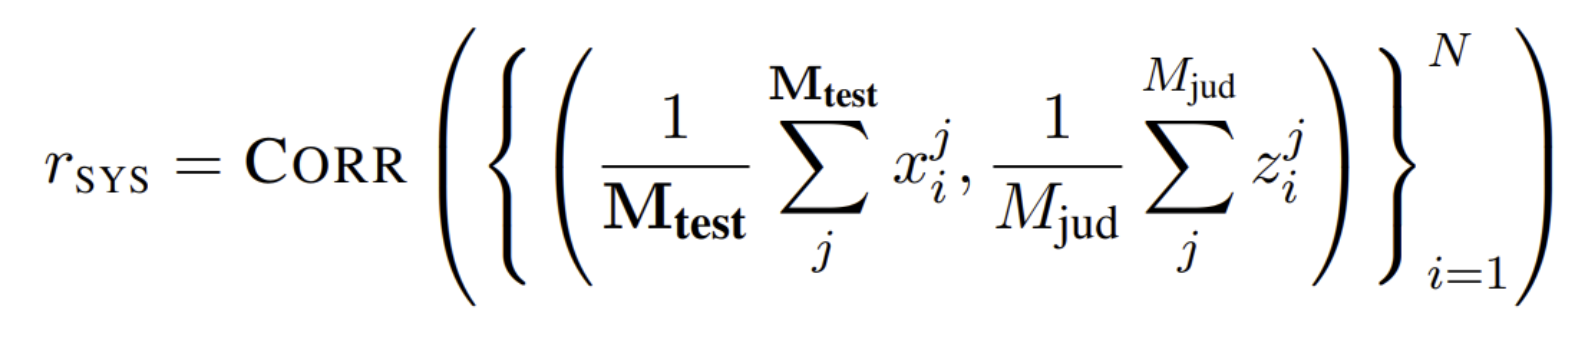

In [ ]:
import scipy.stats as stats
import pandas as pd
import statistics

tau_metrics = metrics[:-1]
models = [file.split(".")[0] for file in files[1:]]
summary_dataset = pd.read_csv("summary_dataset_with_bertscore_bleu_rouge_meteor.csv")
summary_dataset.head()

In [ ]:
print(models)

### ROUGE:

In [70]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_rouge1"
    auto_data.append(statistics.mean(list(summary_dataset[auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))
    
    

In [71]:
print(auto_data)
print(human_data)

[0.3180142892927654, 0.21508826169541576, 0.2660360175188819]
[18.16, 15.1, 17.53]


In [72]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [73]:
print(tau, p_value)

1.0 0.3333333333333333


### METEOR

In [74]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_meteor"
    auto_data.append(statistics.mean(list(summary_dataset[auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))

In [75]:
print(auto_data)
print(human_data)

[0.24891803189571327, 0.12361186012412592, 0.24477757983693155]
[18.16, 15.1, 17.53]


In [76]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [77]:
print(tau, p_value)

1.0 0.3333333333333333


### BertScore

In [84]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_bertscore_f1"
    auto_data.append(statistics.mean(list(summary_dataset[auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))
    

In [85]:
print(auto_data)
print(human_data)

[0.6936039480372626, 0.6652786503672757, 0.664570294984149]
[18.16, 15.1, 17.53]


In [80]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [81]:
print(tau, p_value)

0.33333333333333337 1.0


## Оценка корреляции (Per System, M_judge):

### ROUGE1

In [172]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_rouge1"
    auto_data.append(statistics.mean(list(summary_dataset.iloc[data_dict[index]][auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))

In [173]:
print(auto_data)
print(human_data)

[0.3163712728521068, 0.19519412832011918, 0.2782288617410687]
[18.16, 15.1, 17.53]


In [174]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [175]:
print(tau, p_value)

1.0 0.3333333333333333


In [176]:
from scipy.stats import bootstrap
import numpy as np

def calc_kendalltau(x, y):
    tau = stats.kendalltau(x, y)[0]
    print(tau)
    if math.isnan(tau):
        tau = 0
    return tau

rng = np.random.default_rng(seed=42)
data = (auto_data, human_data)
bootstrap_samples = bootstrap(data, calc_kendalltau, n_resamples=3, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)

1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0


In [177]:
print(bootstrap_samples.confidence_interval)

ConfidenceInterval(low=nan, high=nan)


### METEOR

In [179]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_meteor"
    auto_data.append(statistics.mean(list(summary_dataset.iloc[data_dict[index]][auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))

In [180]:
print(auto_data)
print(human_data)

[0.250234088064963, 0.10929014132371324, 0.2562734896786244]
[18.16, 15.1, 17.53]


In [181]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [182]:
print(tau, p_value)

0.33333333333333337 1.0


In [183]:
from scipy.stats import bootstrap
import numpy as np

def calc_kendalltau(x, y):
    tau = stats.kendalltau(x, y)[0]
    print(tau)
    if math.isnan(tau):
        tau = 0
    return tau

rng = np.random.default_rng(seed=42)
data = (auto_data, human_data)
bootstrap_samples = bootstrap(data, calc_kendalltau, n_resamples=3, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)
print(bootstrap_samples.confidence_interval)

0.33333333333333337
0.9999999999999999
-0.9999999999999999
0.33333333333333337
1.0
-1.0
1.0
ConfidenceInterval(low=-0.814584272175211, high=0.9573296956556513)


### BERTScore F1

In [189]:
auto_data = []
human_data = []
for model in models:
    auto_metric_field_name = f"{model}_bertscore_f1"
    auto_data.append(statistics.mean(list(summary_dataset.iloc[data_dict[index]][auto_metric_field_name])))

    human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
    human_data.append(statistics.mean([sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]) for i in range(100)]))

In [190]:
print(auto_data)
print(human_data)

[0.6933701419830323, 0.6562736624479294, 0.6700835007429123]
[18.16, 15.1, 17.53]


In [191]:
tau, p_value = stats.kendalltau(auto_data, human_data)

In [192]:
print(tau, p_value)

1.0 0.3333333333333333


In [194]:
from scipy.stats import bootstrap
import numpy as np

def calc_kendalltau(x, y):
    tau = stats.kendalltau(x, y)[0]
    if math.isnan(tau):
        tau = 0
    return tau

rng = np.random.default_rng(seed=42)
data = (auto_data, human_data)
bootstrap_samples = bootstrap(data, calc_kendalltau, n_resamples=1000, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)
print(bootstrap_samples.confidence_interval)

ConfidenceInterval(low=nan, high=nan)


## Оценка корреляции (Per Input(!!!))

### ROUGE1

In [93]:
import math
res = []
ci_min = []
ci_max = []
for i, ind in enumerate(data_dict[index]):
    auto_data_temp = []
    human_data_temp = []
    for model in models:
        auto_metric_field_name = f"{model}_rouge1"
        auto_data_temp.append(summary_dataset.iloc[ind][auto_metric_field_name])
    
        human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
        human_data_temp.append(sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]))
    bootstrap_samples = bootstrap((auto_data_temp, human_data_temp), calc_kendalltau, n_resamples=3, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)
    ci = bootstrap_samples.confidence_interval
    if not math.isnan(ci.low):
        ci_min.append(ci.low)
    if not math.isnan(ci.high):
        ci_max.append(ci.high)
    
    tau_temp = stats.kendalltau(auto_data_temp, human_data_temp)[0]
    if math.isnan(tau_temp):
        tau_temp = 0
    res.append(tau_temp)
tau = statistics.mean(res)
ci = [statistics.mean(ci_min), statistics.mean(ci_max)]

KeyError: 'Ind'

In [197]:
print(tau)
print(ci)

0.3384676837096013
[-0.3313045036569242, 0.5946672219571075]


### METEOR

In [198]:
import math
res = []
ci_min = []
ci_max = []
for i, ind in enumerate(data_dict[index]):
    auto_data_temp = []
    human_data_temp = []
    for model in models:
        auto_metric_field_name = f"{model}_meteor"
        auto_data_temp.append(summary_dataset.iloc[ind][auto_metric_field_name])
    
        human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
        human_data_temp.append(sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]))

    bootstrap_samples = bootstrap((auto_data_temp, human_data_temp), calc_kendalltau, n_resamples=3, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)
    ci = bootstrap_samples.confidence_interval
    if not math.isnan(ci.low):
        ci_min.append(ci.low)
    if not math.isnan(ci.high):
        ci_max.append(ci.high)
        
    tau_temp = stats.kendalltau(auto_data_temp, human_data_temp)[0]
    if math.isnan(tau_temp):
        tau_temp = 0
    res.append(tau_temp)
tau = statistics.mean(res)
ci = [statistics.mean(ci_min), statistics.mean(ci_max)]

/home/skatori/.local/lib/python3.11/site-packages/scipy/stats/_resampling.py:150: RuntimeWarning: invalid value encountered in scalar multiply
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/skatori/.local/lib/python3.11/site-packages/scipy/stats/_resampling.py:152: RuntimeWarning: invalid value encountered in scalar multiply
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))


In [199]:
print(tau)
print(ci)

0.3747976153281558
[-0.3356774906080161, 0.6188226238094781]


### BERTScore F1

In [200]:
import math
res = []
ci_min = []
ci_max = []
for i, ind in enumerate(data_dict[index]):
    auto_data_temp = []
    human_data_temp = []
    for model in models:
        auto_metric_field_name = f"{model}_bertscore_f1"
        auto_data_temp.append(summary_dataset.iloc[ind][auto_metric_field_name])
    
        human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
        human_data_temp.append(sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]))

    bootstrap_samples = bootstrap((auto_data_temp, human_data_temp), calc_kendalltau, n_resamples=3, confidence_level=0.9, random_state=rng, paired=True, vectorized=False)
    ci = bootstrap_samples.confidence_interval
    if not math.isnan(ci.low):
        ci_min.append(ci.low)
    if not math.isnan(ci.high):
        ci_max.append(ci.high)
        
    tau_temp = stats.kendalltau(auto_data_temp, human_data_temp)[0]
    if math.isnan(tau_temp):
        tau_temp = 0
    res.append(tau_temp)
tau = statistics.mean(res)
ci = [statistics.mean(ci_min), statistics.mean(ci_max)]

In [201]:
print(tau)
print(ci)

0.27914115380582555
[-0.2564229188531179, 0.5994770096849935]


## Оценка текстов (кластеры качества)

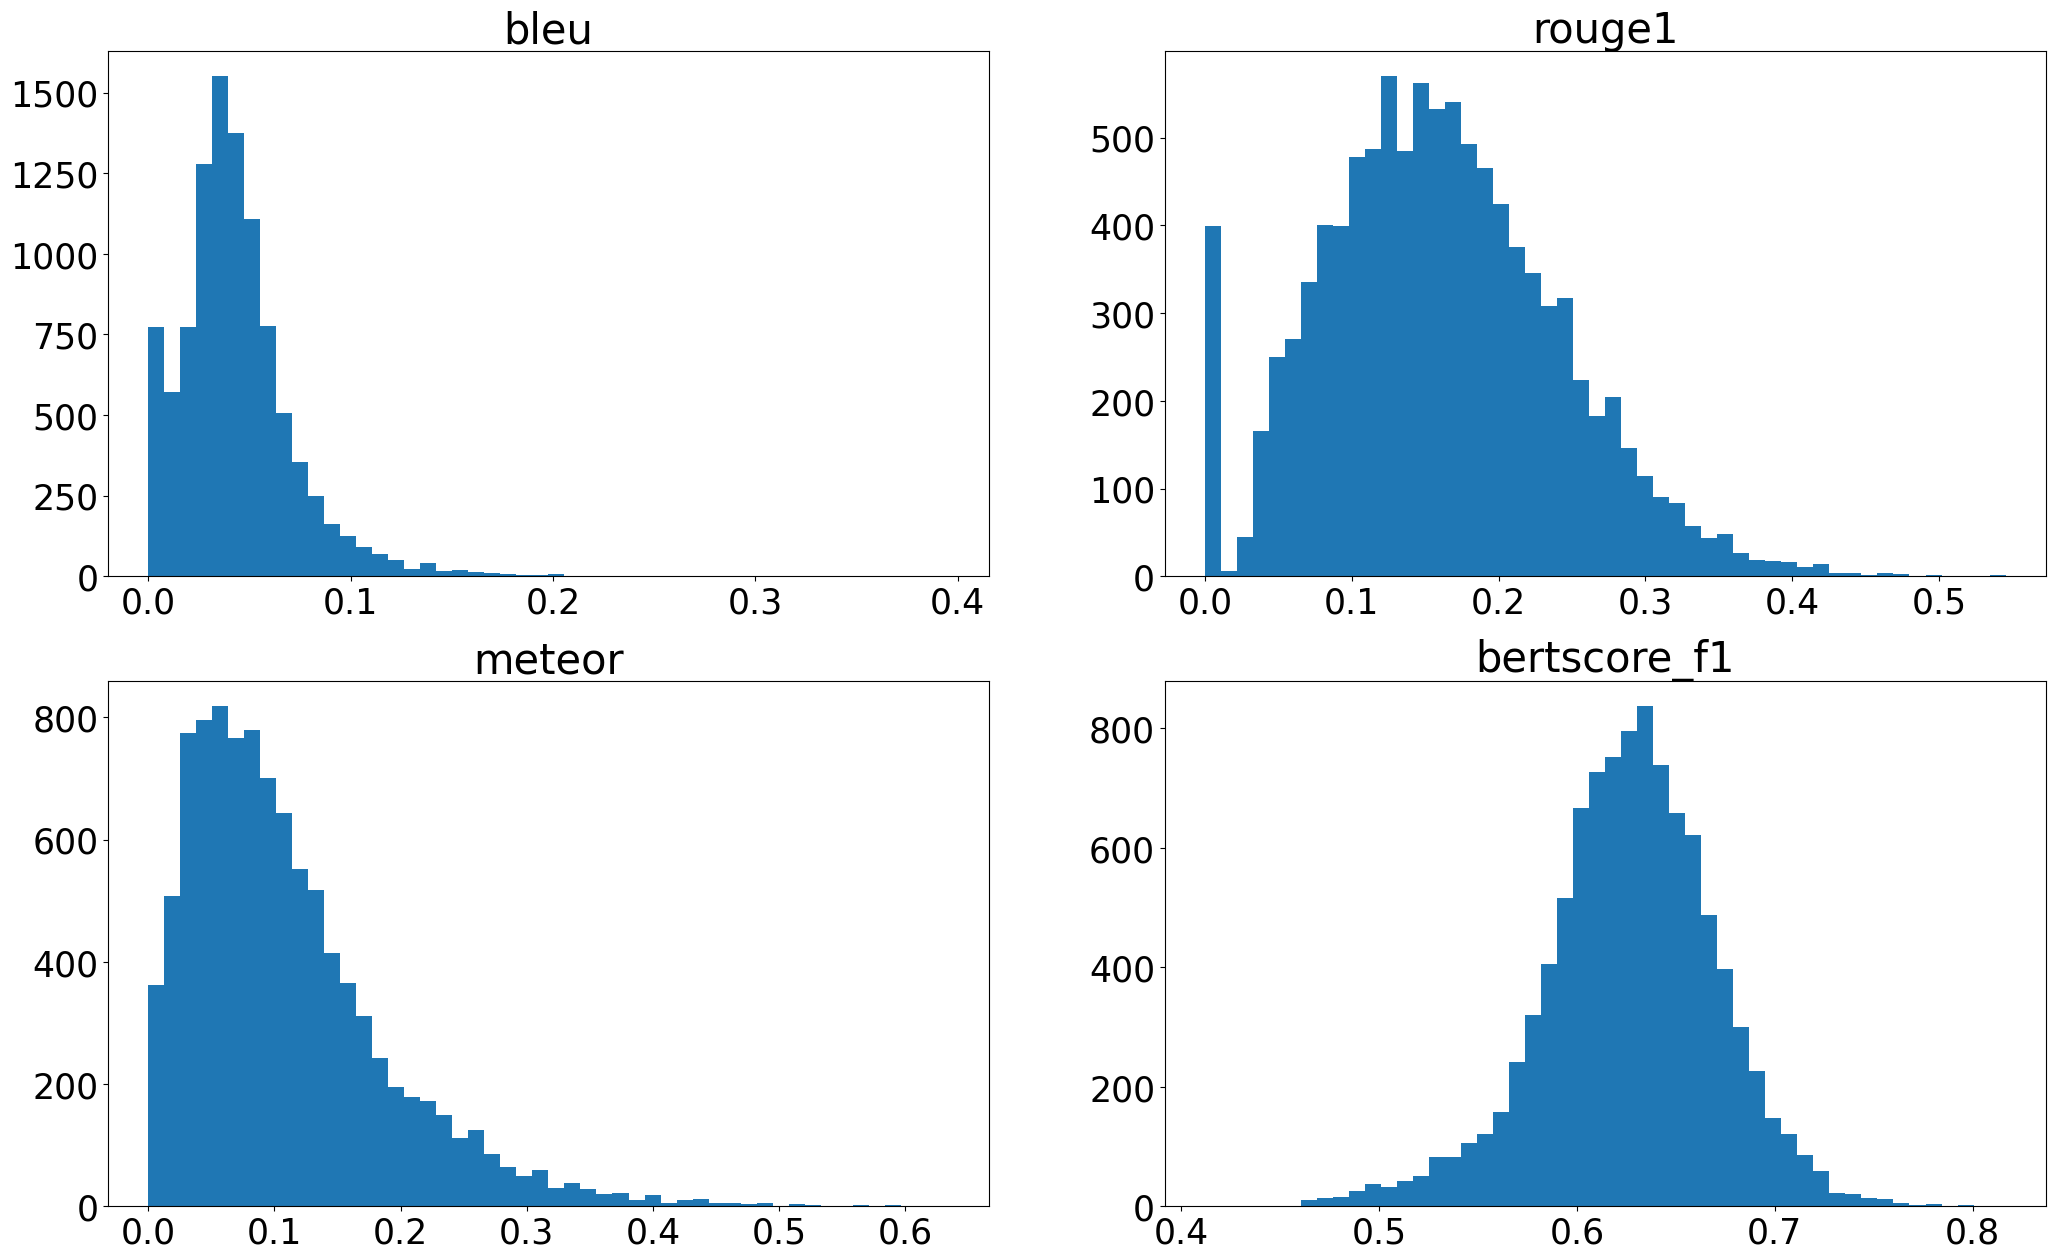

In [102]:
from matplotlib import pyplot as plt
import matplotlib

files = [
     "mbart_predictions.txt",
  "mt5_predictions.txt",
   "summarunner_predictions.txt"
]
models = [file.split(".")[0] for file in files[1:]]

matplotlib.rcParams.update({'font.size': 25})


auto_data = []
human_data = []
cluster_metrics = [
    "bleu",
    "rouge1",
    "meteor",
    "bertscore_f1"
]

fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(25)
for i, metric in enumerate(cluster_metrics):
    values = []
    for model in models:
        auto_metric_field_name = f"{model}_{metric}"
        values += list(summary_dataset[auto_metric_field_name])
    axs[(i // 2, i % 2)].set_title(metric)
    axs[(i // 2, i % 2)].hist(values, bins=50)

plt.show()

In [103]:
summary_dataset.head()

,Ind,title,text,summary,mbart_predictions,mt5_predictions,summarunner_predictions,mbart_predictions_bertscore_precision,mbart_predictions_bertscore_recall,mbart_predictions_bertscore_f1,...,mt5_predictions_rouge2,mt5_predictions_rougeL,mt5_predictions_rougeLsum,summarunner_predictions_rouge1,summarunner_predictions_rouge2,summarunner_predictions_rougeL,summarunner_predictions_rougeLsum,mbart_predictions_meteor,mt5_predictions_meteor,summarunner_predictions_meteor
0,0,wikilingua_multilingual-val-36832,"Есть широкий выбор сортов картофеля, обычно их...",Запланируйте посадку картофеля в соответствии ...,Российский картофель — один из самых популярны...,Созревание картофеля может принесут урожай в т...,с помощью лопаты аккуратно добавьте в горшок р...,0.575211,0.588802,0.581927,...,0.0,0.102564,0.102564,0.258065,0.021978,0.172043,0.172043,0.089767,0.047529,0.129390
1,1,wikilingua_multilingual-val-36833,"Вы не сможете найти красного люциана без кожи,...",Используйте филе без кожи. Подготовьте жидкое ...,"Начните приготовление красного люциана, которы...",Японская панировка красного люциана - самая по...,попробуйте положить филе и тесто вместе в паке...,0.646338,0.753633,0.695874,...,0.0,0.078431,0.078431,0.263158,0.027027,0.210526,0.210526,0.241247,0.032573,0.165663
2,2,wikilingua_multilingual-val-36834,Груши должны быть красно-оранжевого или пурпур...,Купите или вырастите грушу. Удалите шипы. Очис...,"В сегодняшнем обзоре мы расскажем о том, как с...",Груши с белой кожурой - одна из самых популярн...,режьте вдоль верхней и нижней части груши по ц...,0.589720,0.599384,0.594513,...,0.0,0.086957,0.086957,0.322581,0.100000,0.258065,0.258065,0.057034,0.038168,0.228597
3,3,wikilingua_multilingual-val-36835,Со светлыми волосами вам придется изменить сво...,"Учтите образ жизни. Подумайте о том, насколько...",Со светлыми волосами вам придется изменить сво...,"Если вы хотите стать блондинкой, то наверняка ...","скажите им, что вы хотите стать блондинкой, и ...",0.607002,0.655611,0.630370,...,0.0,0.125000,0.125000,0.150943,0.000000,0.150943,0.150943,0.280463,0.067568,0.127119
4,4,wikilingua_multilingual-val-36836,Если мяч уходит немного влево (у игроков с пра...,Откорректируйте слайс. Откорректируйте хук. Ис...,В преддверии матча чемпионата мира по хоккею с...,"Если мяч летит немного вправо, а затем резко н...",обратите внимание на свой хват. чтобы убедитьс...,0.528840,0.520251,0.524510,...,0.0,0.186047,0.186047,0.185185,0.000000,0.148148,0.148148,0.060606,0.280463,0.137363


In [104]:
summary_dataset.to_csv("wikilingua_merge_candidate.csv", index=False)

# Backup

In [202]:
data_dict_df = pd.DataFrame(data_dict)

In [203]:
data_dict_df.head()

,Ind,text,summary,summary_Актуальность,summary_Последовательность,summary_Беглость,summary_Согласованность,summary_Комментарий,mbart_predictions,mbart_predictions_Актуальность,...,mt5_predictions_Последовательность,mt5_predictions_Беглость,mt5_predictions_Согласованность,mt5_predictions_Комментарий,summarunner_predictions,summarunner_predictions_Актуальность,summarunner_predictions_Последовательность,summarunner_predictions_Беглость,summarunner_predictions_Согласованность,summarunner_predictions_Комментарий
0,53,Постоянно включенный Bluetooth на смартфоне гр...,Активированный в смартфоне Bluetooth может пре...,[5],[5],[5],[5],[nan],Постоянно включенный Bluetooth на смартфоне гр...,[4],...,[1],[3],[2],[nan],постоянно включенный bluetooth на смартфоне гр...,[4],[5],[4],[4],[nan]
1,204,Китайское издание Sina высоко оценило новый ро...,Новый российский боевой железнодорожный ракетн...,[5],[5],[5],[5],[nan],Китайское издание Sina высоко оценило новый ро...,[4],...,[1],[1],[1],[nan],китайское издание sina высоко оценило новый ро...,[5],[5],[4],[4],[nan]
2,217,8 сентября в Японии официально стартовала изби...,Генеральный секретарь кабинета министров Япони...,[5],[5],[5],[5],[nan],В Японии официально стартовала избирательная к...,[4],...,[2],[5],[1],[nan],8 сентября в японии официально стартовала изби...,[3],[4],[5],[4],[nan]
3,244,Член президиума координационного совета оппози...,Члена президиума оппозиционного Координационно...,[5],[5],[5],[5],[nan],Член президиума координационного совета оппози...,[4],...,[3],[5],[5],[nan],член президиума координационного совета оппози...,[3],[3],[4],[4],[nan]
4,260,Аналитики Deutsche Bank обнародовали исследова...,В истории человечества наступает эпоха беспоря...,[5],[5],[5],[5],[nan],В 2020 году в мире наступит новая эпоха беспор...,[4],...,[3],[5],[1],[nan],аналитики deutsche bank обнародовали исследова...,[5],[5],[5],[5],[nan]


In [204]:
data_dict_df.to_csv("compiled_expert_data.csv")

# Automatic baseline

In [276]:
import math

def compute_taus(metric_name):
    res = []
    ci_min = []
    ci_max = []
    data_dict[f"{metric_name}_tau"] = []
    for i, ind in enumerate(data_dict[index]):
        auto_data_temp = []
        human_data_temp = []
        for model in models:
            auto_metric_field_name = f"{model}_{metric_name}"
            auto_data_temp.append(summary_dataset.iloc[ind][auto_metric_field_name])
        
            human_metrics_fields = [f"{model}_{metric}" for metric in tau_metrics]
            human_data_temp.append(sum([statistics.mean(data_dict[field][i]) for field in human_metrics_fields]))
        
        tau_temp = stats.kendalltau(auto_data_temp, human_data_temp)[0]
        if math.isnan(tau_temp):
            tau_temp = 0
        res.append(tau_temp)
        data_dict[f"{metric_name}_tau"].append(tau_temp)
    tau = statistics.mean(res)

In [277]:
from datasets import Dataset

compute_taus("rouge1")
print(len([x for x in data_dict["rouge1_tau"] if x > 0.5]))
data = []
for i, ind in enumerate(data_dict["Ind"]):
    data.append({"text": data_dict["text"][i], "label": 0 if data_dict["rouge1_tau"][i] <= 0.5 else 1})
dataset_rouge1 = Dataset.from_list(data)
dataset_rouge1 = dataset_rouge1.train_test_split(test_size=0.1)

42


In [278]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)
    
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruRoberta-large")
tokenized_dataset_rouge1 = dataset_rouge1.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [279]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "NONE", 1: "POSITIVE"}
label2id = {"NONE": 0, "POSITIVE": 1}

In [280]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "ai-forever/ruRoberta-large", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [281]:
id2label = {0: "NONE", 1: "POSITIVE"}
label2id = {"NONE": 0, "POSITIVE": 1}

training_args = TrainingArguments(
    output_dir="automatic_baseline",
    learning_rate=4e-7,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_rouge1["train"],
    eval_dataset=tokenized_dataset_rouge1["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.619289,0.700000
2,No log,0.621302,0.700000
3,No log,0.614546,0.700000
4,No log,0.632579,0.700000
5,No log,0.642624,0.700000
6,No log,0.643212,0.600000
7,No log,0.642053,0.600000
8,No log,0.645305,0.600000
9,No log,0.642706,0.600000
10,No log,0.648333,0.600000


Checkpoint destination directory automatic_baseline/checkpoint-23 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-46 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-69 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-92 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-115 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-138 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory automatic_baseline/checkpoint-161 already exists and 

TrainOutput(global_step=1150, training_loss=0.48656204887058424, metrics={'train_runtime': 674.7446, 'train_samples_per_second': 6.669, 'train_steps_per_second': 1.704, 'total_flos': 4193691134976000.0, 'train_loss': 0.48656204887058424, 'epoch': 50.0})

In [275]:
import gc
import torch

model = None
tokenizer = None
gc.collect()
torch.cuda.empty_cache() 